In [2]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [3]:
ppo = parse_tensorboard(path='./output_malota/PPO_8', scalars=['rollout/ep_rew_mean'])

In [24]:
TAG ="train/entropy_loss"
models = {
    'PPO_MlpLstm_zbior_3': parse_tensorboard(path='./output_malota/RecurrentPPO_19', scalars=[TAG]),
    'PPO_MlpLstm_zbior_3_2': parse_tensorboard(path='./output_malota/RecurrentPPO_20', scalars=[TAG]),
}

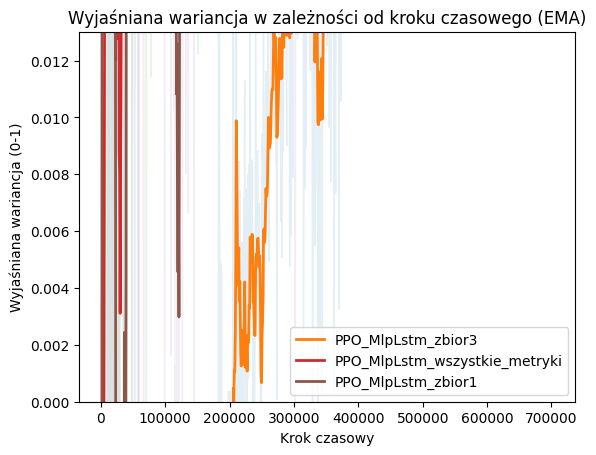

In [6]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TAG = "train/explained_variance"
SPAN = 10   # ← EMA smoothness (higher = smoother, more lag)

models = {
    'PPO_MlpLstm_zbior3':   parse_tensorboard(path='./output_malota/RecurrentPPO_19', scalars=[TAG]),
    'PPO_MlpLstm_zbior3_2': parse_tensorboard(path='./output_malota/RecurrentPPO_20', scalars=[TAG]),
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path='./output_malota/RecurrentPPO_22', scalars=[TAG]),
    'PPO_MlpLstm_zbior1': parse_tensorboard(path='./output_malota/RecurrentPPO_14', scalars=[TAG]),
    'PPO_MlpLstm_zbior1_2': parse_tensorboard(path='./output_malota/RecurrentPPO_16', scalars=[TAG]),
    'PPO_MlpLstm_zbior1_3': parse_tensorboard(path='./output_malota/RecurrentPPO_26', scalars=[TAG]),
}

# ---- helpers ----

def to_df(parsed, tag):
    """Normalize parse_tensorboard() output to a DataFrame with ['step','value']"""
    if isinstance(parsed, pd.DataFrame):
        df = parsed.copy()
        if "tag" in df.columns:
            df = df[df["tag"] == tag]
    elif isinstance(parsed, dict):
        df = parsed[tag].copy()
    else:
        raise TypeError("Unsupported parse_tensorboard output type.")
    if not {"step", "value"}.issubset(df.columns):
        raise ValueError("Expected columns 'step' and 'value' in parsed TF data.")
    return df[["step", "value"]].sort_values("step").reset_index(drop=True)

def step_spacing(df):
    """Robust default step gap for offsetting."""
    gap = df["step"].diff().median()
    if pd.isna(gap) or gap <= 0:
        gap = 1
    return int(gap)

def join_chain(run_dfs):
    """
    Given a list of DataFrames for a chain [df1, df2, ...] (already ordered),
    offset subsequent runs so they continue after the previous.
    Returns concatenated df with ['global_step','value'].
    """
    out = []
    offset = 0
    prev_gap = None

    for i, df in enumerate(run_dfs):
        df = df.copy()
        if i == 0:
            df["global_step"] = df["step"]
            prev_gap = step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        else:
            df["global_step"] = df["step"] + offset
            # keep previous spacing to avoid gaps
            prev_gap = prev_gap if prev_gap is not None else step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        out.append(df[["global_step", "value"]])

    return pd.concat(out, ignore_index=True)

def split_into_chains(models_dict):
    """
    Group model names into chains by a suffix pattern *_N (N >= 2).
    Name without numeric suffix = N=1. Returns dict: base -> [name ordered by N].
    """
    pat = re.compile(r"^(.*?)(?:_(\d+))?$")
    registry = {}  # base -> list of (n, name)

    for name in models_dict:
        m = pat.match(name)
        base = m.group(1) if m else name
        n = int(m.group(2)) if (m and m.group(2)) else 1
        registry.setdefault(base, []).append((n, name))

    chains = {base: [nm for n, nm in sorted(entries, key=lambda x: x[0])]
              for base, entries in registry.items()}
    return chains

def smooth_ema(df, span=SPAN):
    """EMA smoothing of 'value' over 'global_step'."""
    d = df.sort_values("global_step").copy()
    d["smooth"] = d["value"].ewm(span=span, adjust=False).mean()
    return d

# ---- main ----

chains = split_into_chains(models)

all_joined = []          # raw concatenated data
all_joined_smooth = []   # with EMA smoothing

plt.figure()

for base, names in chains.items():
    # convert each run to df
    run_dfs = []
    for nm in names:
        try:
            run_dfs.append(to_df(models[nm], TAG))
        except Exception as e:
            print(f"Skipping {nm} due to error: {e}")
    if not run_dfs:
        continue

    joined = join_chain(run_dfs)
    joined["chain"] = base
    all_joined.append(joined)

    # Smooth and plot
    sm = smooth_ema(joined, span=SPAN)
    sm["chain"] = base
    all_joined_smooth.append(sm)

    # Optional: faint raw curve in the background
    plt.plot(joined["global_step"], joined["value"], alpha=0.12, linewidth=1)

    # Smoothed curve
    plt.plot(sm["global_step"], sm["smooth"], label=base, linewidth=2)

# Combine to single DataFrames
all_joined = pd.concat(all_joined, ignore_index=True) if all_joined else pd.DataFrame()
all_joined_smooth = pd.concat(all_joined_smooth, ignore_index=True) if all_joined_smooth else pd.DataFrame()

plt.xlabel("Krok czasowy")
plt.ylabel("Wyjaśniana wariancja (0-1)")
plt.title("Wyjaśniana wariancja w zależności od kroku czasowego (EMA)")
plt.ylim(0, 0.013)   # y-axis cap
plt.legend()
plt.show()

# all_joined       -> columns: ['global_step', 'value', 'chain']
# all_joined_smooth-> columns: ['global_step', 'value', 'smooth', 'chain']


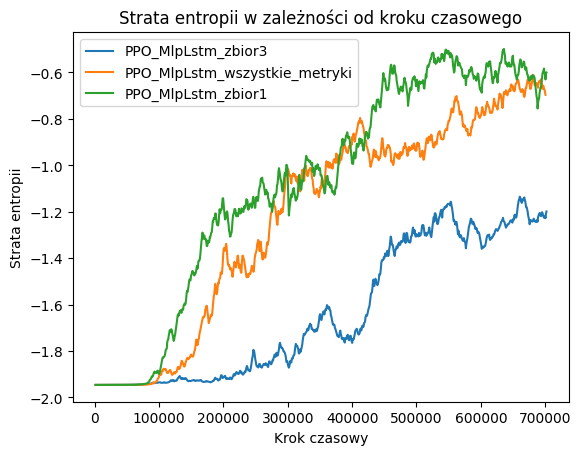

In [9]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TAG = "train/entropy_loss"
models = {
    'PPO_MlpLstm_zbior3':   parse_tensorboard(path='./output_malota/RecurrentPPO_19', scalars=[TAG]),
    'PPO_MlpLstm_zbior3_2': parse_tensorboard(path='./output_malota/RecurrentPPO_20', scalars=[TAG]),
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path='./output_malota/RecurrentPPO_22', scalars=[TAG]),
    'PPO_MlpLstm_zbior1': parse_tensorboard(path='./output_malota/RecurrentPPO_14', scalars=[TAG]),
    'PPO_MlpLstm_zbior1_2': parse_tensorboard(path='./output_malota/RecurrentPPO_16', scalars=[TAG]),
    'PPO_MlpLstm_zbior1_3': parse_tensorboard(path='./output_malota/RecurrentPPO_26', scalars=[TAG]),
    # add more pairs here
}
# ---- helpers ----

def to_df(parsed, tag):
    """Normalize parse_tensorboard() output to a DataFrame with ['step','value']"""
    if isinstance(parsed, pd.DataFrame):
        df = parsed.copy()
        if "tag" in df.columns:
            df = df[df["tag"] == tag]
    elif isinstance(parsed, dict):
        df = parsed[tag].copy()
    else:
        raise TypeError("Unsupported parse_tensorboard output type.")
    need = [c for c in ["step", "value"] if c in df.columns]
    if not set(["step","value"]).issubset(df.columns):
        raise ValueError("Expected columns 'step' and 'value' in parsed TF data.")
    return df[need].sort_values("step").reset_index(drop=True)

def step_spacing(df):
    """Robust default step gap for offsetting."""
    gap = df["step"].diff().median()
    if pd.isna(gap) or gap <= 0:
        gap = 1
    return int(gap)

def join_chain(run_dfs):
    """
    Given a list of DataFrames for a chain [df1, df2, ...] (already ordered),
    offset subsequent runs so they continue after the previous.
    Returns concatenated df with ['global_step','value','segment'].
    """
    out = []
    offset = 0
    prev_gap = None

    for i, df in enumerate(run_dfs):
        df = df.copy()
        if i == 0:
            df["global_step"] = df["step"]
            prev_gap = step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        else:
            # use previous segment's spacing for continuity
            df["global_step"] = df["step"] + offset
            prev_gap = step_spacing(df) if prev_gap is None else prev_gap
            offset = int(df["global_step"].max()) + prev_gap
        out.append(df[["global_step","value"]])

    return pd.concat(out, ignore_index=True)

def split_into_chains(models_dict):
    """
    Group model names into chains by a suffix pattern *_N (N >= 2).
    Name without numeric suffix = N=1. Returns dict: base -> [name ordered by N].
    """
    pat = re.compile(r"^(.*?)(?:_(\d+))?$")
    registry = {}  # base -> list of (n, name)

    for name in models_dict:
        m = pat.match(name)
        if not m:
            base, n = name, 1
        else:
            base = m.group(1)
            n = int(m.group(2)) if m.group(2) else 1
        registry.setdefault(base, []).append((n, name))

    # sort by numeric n and return names only
    chains = {base: [nm for n, nm in sorted(entries, key=lambda x: x[0])]
              for base, entries in registry.items()}
    return chains

# ---- main ----


chains = split_into_chains(models)

all_joined = []  # will collect every chain’s concatenated df

plt.figure()

for base, names in chains.items():
    # convert each run to df
    run_dfs = []
    for nm in names:
        try:
            run_dfs.append(to_df(models[nm], TAG))
        except Exception as e:
            print(f"Skipping {nm} due to error: {e}")
    if not run_dfs:
        continue

    joined = join_chain(run_dfs)
    joined["chain"] = base  # label the chain for downstream analysis
    all_joined.append(joined)

    # single curve per chain
    plt.plot(joined["global_step"], joined["value"], label=base)


all_joined = pd.concat(all_joined, ignore_index=True)

plt.xlabel("Krok czasowy")
plt.ylabel("Strata entropii")
plt.title("Strata entropii w zależności od kroku czasowego")
#plt.ylim(0, 0.013)   # 👈 cap y-axis
plt.legend()
plt.show()


# all_joined columns: ['global_step', 'value', 'chain']
# If you also want original 'step' or run markers inside all_joined, you can add them above.


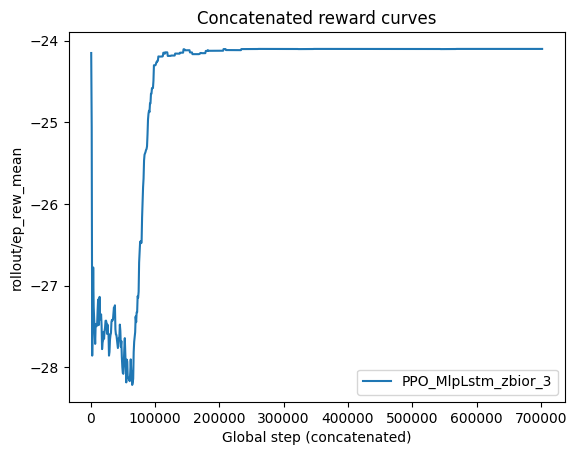

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

TAG = "rollout/ep_rew_mean"

def to_df(run_name, parsed, tag):
    """Convert parse_tensorboard output into a clean df with step/value."""
    if isinstance(parsed, pd.DataFrame):
        df = parsed.copy()
        if "tag" in df.columns:
            df = df[df["tag"] == tag]
    elif isinstance(parsed, dict):
        df = parsed[tag].copy()
    else:
        raise TypeError("Unsupported parse_tensorboard output type.")
    return df[["step", "value"]].sort_values("step").reset_index(drop=True)

def join_pair(df1, df2):
    """Offset df2 steps so it starts after df1 ends, return concatenated df."""
    last_step_1 = int(df1["step"].max())
    step_gap = df1["step"].diff().median()
    if pd.isna(step_gap) or step_gap <= 0:
        step_gap = 1
    offset = last_step_1 + step_gap

    df1 = df1.copy()
    df2 = df2.copy()
    df1["global_step"] = df1["step"]
    df2["global_step"] = df2["step"] + offset

    return pd.concat([df1, df2], ignore_index=True).sort_values("global_step")

# ---- MAIN ----


# Detect pairs by name (simple: assume keys ending with "_2" are continuations)
pairs = {}
for name in models.keys():
    if name.endswith("_2"):
        base = name[:-2]
        if base in models:
            pairs[base] = (models[base], models[name])

plt.figure()

for base, (m1, m2) in pairs.items():
    df1 = to_df(base, m1, TAG)
    df2 = to_df(base + "_2", m2, TAG)
    joined = join_pair(df1, df2)

    # plot
    plt.plot(joined["global_step"], joined["value"], label=base)

plt.xlabel("Global step (concatenated)")
plt.ylabel(TAG)
plt.title("Concatenated reward curves")
plt.legend()
plt.show()


No handles with labels found to put in legend.


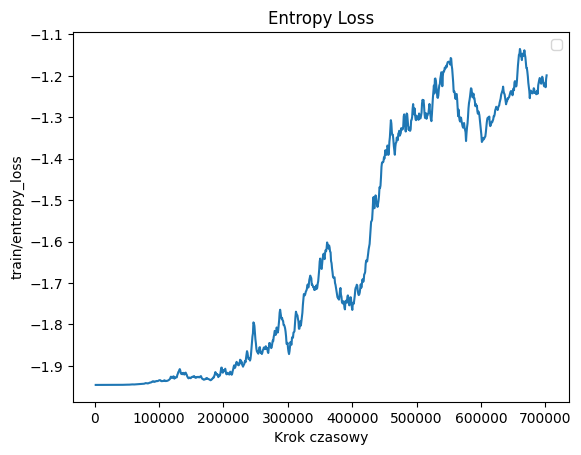

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#"rollout/ep_rew_mean"

# Helper to extract a tidy df with columns: step, value, run
def _to_df(run_name, parsed, tag):
    """
    Works with common parse_tensorboard outputs:
    - either a single DataFrame containing multiple tags/runs (has 'tag'/'run' columns)
    - or a dict {tag: DataFrame}
    """
    if isinstance(parsed, pd.DataFrame):
        df = parsed.copy()
        if "tag" in df.columns:
            df = df[df["tag"] == tag]
        if "run" not in df.columns:
            df["run"] = run_name
    elif isinstance(parsed, dict):
        # typical: parsed[tag] -> DataFrame with 'step','value','wall_time'
        df = parsed[tag].copy()
        df["run"] = run_name
    else:
        raise TypeError("Unsupported parse_tensorboard output type.")
    # keep only needed cols
    cols = [c for c in ["step", "value", "wall_time", "run"] if c in df.columns]
    return df[cols].sort_values("step").reset_index(drop=True)

# Get dataframes for the two runs
df1 = _to_df("PPO_MlpLstm_zbior_3",                models["PPO_MlpLstm_zbior_3"], TAG)
df2 = _to_df("PPO_MlpLstm_zbior_3_2",       models["PPO_MlpLstm_zbior_3_2"], TAG)


# Determine an appropriate offset for df2's steps
last_step_1 = int(df1["step"].max())
# try to respect the typical step spacing; default to 1 if unknown
step_gap = df1["step"].diff().median()
if pd.isna(step_gap) or step_gap <= 0:
    step_gap = 1

offset = last_step_1 + step_gap  # so df2 starts right after df1 ends

df1["global_step"] = df1["step"]
df2["global_step"] = df2["step"] + offset

# (Optional) also continue wall_time if you want a time-based x-axis
if "wall_time" in df1.columns and "wall_time" in df2.columns:
    # shift df2 wall_time so its first timestamp follows df1's last
    last_t = df1["wall_time"].max()
    dt = df2["wall_time"].iloc[0] - df2["wall_time"].min()  # usually 0
    wall_shift = (last_t - df2["wall_time"].iloc[0]) + 1e-6
    df2["wall_time_cont"] = df2["wall_time"] + wall_shift

combo = pd.concat([df1, df2], ignore_index=True).sort_values("global_step")

# Plot by global_step (continuous x-axis)
plt.figure()
sub=combo
plt.plot(sub["global_step"], sub["value"])
plt.xlabel("Krok czasowy")
plt.ylabel(TAG)
plt.legend()
plt.title("Entropy Loss")

plt.show()


Text(0.5, 1.0, 'Średnia nagroda za epizod podczas uczenia')

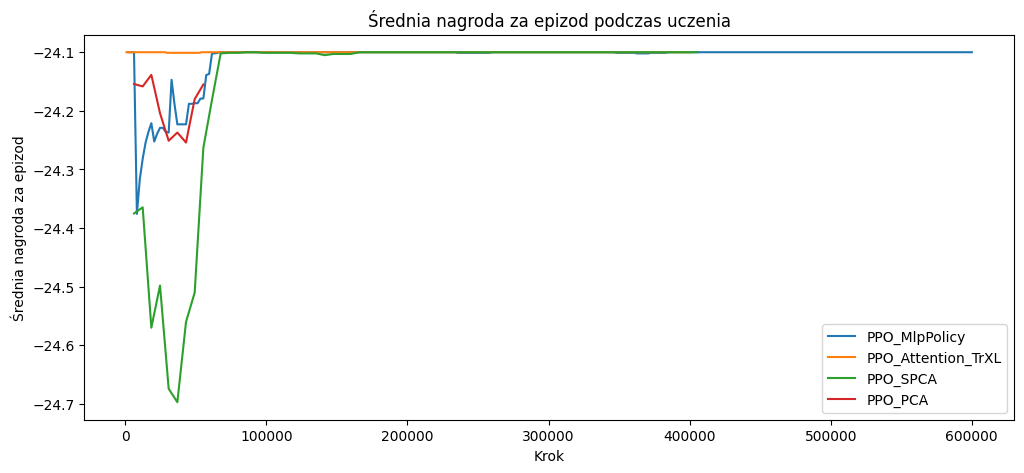

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
for model, data in models.items():
    plt.plot(data['rollout/ep_rew_mean']['step'], data['rollout/ep_rew_mean']['value'])

plt.legend(list(models.keys()))
plt.xlabel("Krok")
plt.ylabel("Średnia nagroda za epizod")
plt.title("Średnia nagroda za epizod podczas uczenia")

In [19]:
models = {
    'PPO_MlpPolicy': parse_tensorboard(path='./output_malota/PPO_8', scalars=['rollout/ep_rew_mean']),
    'PPO_3_cechy_wejściowe_Attention': parse_tensorboard(path='./output_malota/PPO_70', scalars=['rollout/ep_rew_mean']),
    'PPO_3_cech_wejściowe_SPCA': parse_tensorboard(path='./output_malota/PPO_72', scalars=['rollout/ep_rew_mean'])
}

Text(0.5, 1.0, 'Średnia nagroda za epizod podczas uczenia')

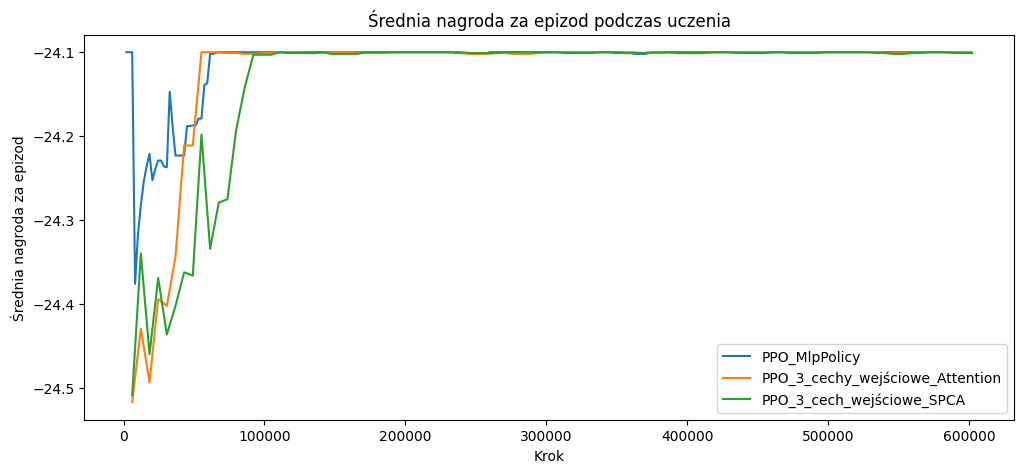

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
for model, data in models.items():
    plt.plot(data['rollout/ep_rew_mean']['step'], data['rollout/ep_rew_mean']['value'])

plt.legend(list(models.keys()))
plt.xlabel("Krok")
plt.ylabel("Średnia nagroda za epizod")
plt.title("Średnia nagroda za epizod podczas uczenia")

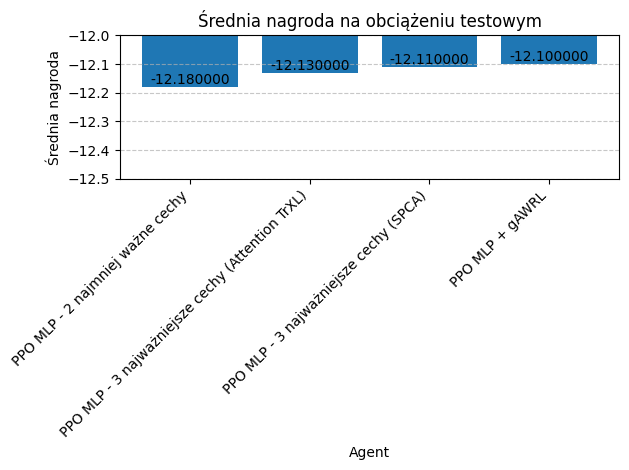

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of paths to DataFrame files
list_of_paths = [r'C:\initial_model\historic_3\ppo_masked_PPO_73_worst_features\ppo_MlpPolicy_mlp_600_000_masked_3_worst_features.csv', 
                 r'C:\initial_model\eval_results\ppo_MlpPolicy_mlp_600_000_masked_3_test_dnnevo.csv', 
                 r'C:\initial_model\historic_3\ppo_masked_PPO_72_SPCA\TEST-DNNEVO\ppo_MlpPolicy_mlp_600_000_masked_3_spca_based.csv',
                 r'C:\initial_model\historic_3\gawrl_old_PPO_1\TEST-DNNEVO\attention_MlpPolicy_mlp_gawrl_viz.csv'
                 ]  # Example paths
labels = ['PPO MLP - 2 najmniej ważne cechy', 'PPO MLP - 3 najważniejsze cechy (Attention TrXL)', 'PPO MLP - 3 najważniejsze cechy (SPCA)', 'PPO MLP + gAWRL']
means = []
#labels = []

for path in list_of_paths:
    df = pd.read_csv(path)  # Adjust read function if necessary (e.g., pd.read_parquet)
    mean_rew = df['rew'].mean()
    means.append(mean_rew)
    labels = labels
    #labels.append(path.split('/')[-1])  # Use filename as label
# Create bar plot
x_pos = np.arange(len(labels))
bars = plt.bar(x_pos, means)

# Set y-axis limits to focus on the range of interest
plt.ylim(-12.5, -12)

# Add value labels on top of each bar
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{mean_val:.6f}',  # Format to 6 decimal places for precision
             ha='center', va='bottom', rotation=0)

plt.xlabel('Agent')
plt.ylabel('Średnia nagroda')
plt.title('Średnia nagroda na obciążeniu testowym')
plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.tight_layout()

# Add a horizontal grid for better reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of paths to DataFrame files
list_of_paths = [
                 r'C:\initial_model\historic_3\gawrl_old_PPO_1\TEST-DNNEVO\attention_MlpPolicy_mlp_gawrl_viz.csv'
                 ]  # Example paths
labels = ['PPO MLP - 2 najmniej ważne cechy', 'PPO MLP - 3 najważniejsze cechy (Attention TrXL)', 'PPO MLP - 3 najważniejsze cechy (SPCA)', 'PPO MLP + gAWRL']
means = []
#labels = []

for path in list_of_paths:
    df = pd.read_csv(path)  # Adjust read function if necessary (e.g., pd.read_parquet)
    mean_rew = df['rew'].mean()
    means.append(mean_rew)
    labels = labels
    #labels.append(path.split('/')[-1])  # Use filename as label
# Create bar plot
x_pos = np.arange(len(labels))
bars = plt.bar(x_pos, means)

# Set y-axis limits to focus on the range of interest
plt.ylim(-12.5, -12)

# Add value labels on top of each bar
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{mean_val:.6f}',  # Format to 6 decimal places for precision
             ha='center', va='bottom', rotation=0)

plt.xlabel('Agent')
plt.ylabel('Średnia nagroda')
plt.title('Średnia nagroda na obciążeniu testowym')
plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.tight_layout()

# Add a horizontal grid for better reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


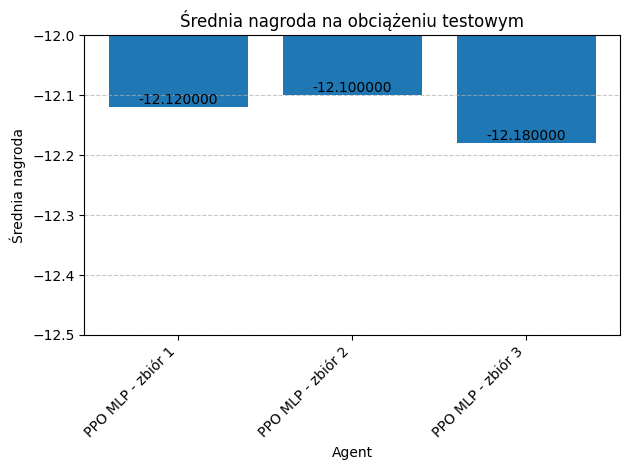

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of paths to DataFrame files
list_of_paths = [
                 r'C:\initial_model\historic_synthetic_dnnevo\PPO_32_avgcpu_waitingglobal_vm\TEST=DNNEVO\ppo_MlpPolicy_mlp_vm_waiting.csv', 
                 r'C:\initial_model\historic_synthetic_dnnevo\PPO_37_vm_global_recent\TEST-DNNEVO\ppo_MlpPolicy_mlp_vm_waiting.csv', 
                 r'C:\initial_model\historic_synthetic_dnnevo\PPO_39_p90_avgmem\TEST-DNNEVO\ppo_MlpPolicy_mlp_vm_waiting.csv'
                 ]  # Example paths
labels = ['PPO MLP - zbiór 1', 'PPO MLP - zbiór 2', 'PPO MLP - zbiór 3']
means = []
#labels = []

for path in list_of_paths:
    df = pd.read_csv(path)  # Adjust read function if necessary (e.g., pd.read_parquet)
    mean_rew = df['rew'].mean()
    means.append(mean_rew)
    labels = labels
    #labels.append(path.split('/')[-1])  # Use filename as label
# Create bar plot
x_pos = np.arange(len(labels))
bars = plt.bar(x_pos, means)

# Set y-axis limits to focus on the range of interest
plt.ylim(-12.5, -12)

# Add value labels on top of each bar
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{mean_val:.6f}',  # Format to 6 decimal places for precision
             ha='center', va='bottom', rotation=0)

plt.xlabel('Agent')
plt.ylabel('Średnia nagroda')
plt.title('Średnia nagroda na obciążeniu testowym')
plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.tight_layout()

# Add a horizontal grid for better reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


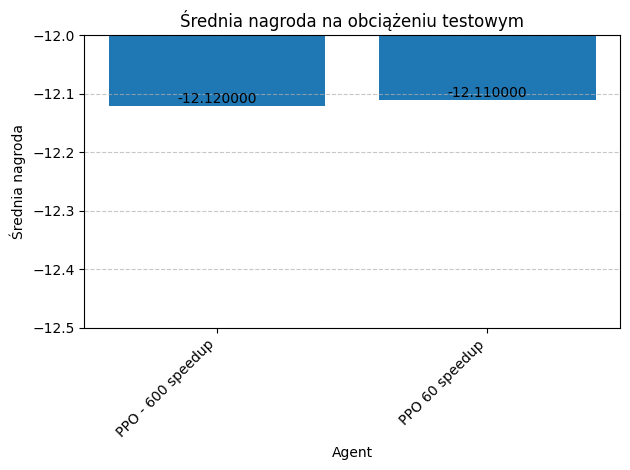

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of paths to DataFrame files
list_of_paths = [
                 #r'C:\initial_model\historic_synthetic_dnnevo\PPO_32_avgcpu_waitingglobal_vm\TEST=DNNEVO\ppo_MlpPolicy_mlp_vm_waiting.csv', 
                # r'C:\initial_model\historic_synthetic_dnnevo\PPO_37_vm_global_recent\TEST-DNNEVO\ppo_MlpPolicy_mlp_vm_waiting.csv', 
                 #r'C:\initial_model\historic_synthetic_dnnevo\PPO_39_p90_avgmem\TEST-DNNEVO\ppo_MlpPolicy_mlp_vm_waiting.csv',
                 # PPO baseline with 600 speedup
                 r'C:\initial_model\historic_synthetic_dnnevo\PPO_40_speedup_600\TEST-DNNEVO\ppo_MlpPolicy_mlp_baseline.csv',
                 # PPO baseline with 60 speedup
                 r'C:\initial_model\historic_synthetic_dnnevo\PPO_43_baseline\TEST-DNNEVO\ppo_MlpPolicy_mlp_baseline.csv'
                 ]  # Example paths
labels = [#'PPO MLP - zbiór 1', 'PPO MLP - zbiór 2', 'PPO MLP - zbiór 3', 
          'PPO - 600 speedup', 'PPO 60 speedup']
means = []
#labels = []

for path in list_of_paths:
    df = pd.read_csv(path)  # Adjust read function if necessary (e.g., pd.read_parquet)
    mean_rew = df['rew'].mean()
    means.append(mean_rew)
    labels = labels
    #labels.append(path.split('/')[-1])  # Use filename as label
# Create bar plot
x_pos = np.arange(len(labels))
bars = plt.bar(x_pos, means)

# Set y-axis limits to focus on the range of interest
plt.ylim(-12.5, -12)

# Add value labels on top of each bar
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{mean_val:.6f}',  # Format to 6 decimal places for precision
             ha='center', va='bottom', rotation=0)

plt.xlabel('Agent')
plt.ylabel('Średnia nagroda')
plt.title('Średnia nagroda na obciążeniu testowym')
plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.tight_layout()

# Add a horizontal grid for better reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


[-12.10000018030405, -12.450000185519457, -12.233333515624205]
['PPO + Attention', 'PPO baseline', 'PPO + SPCA']


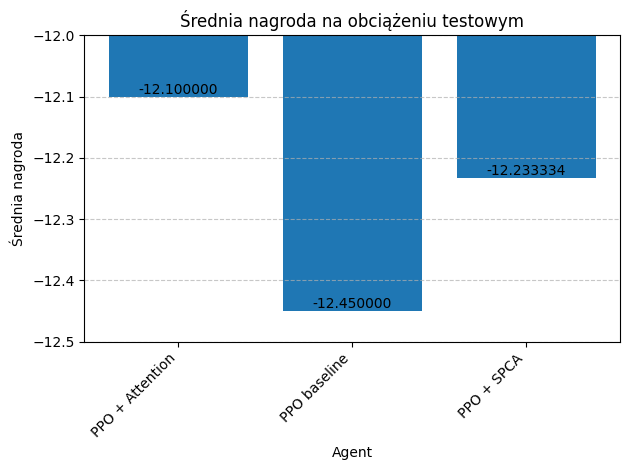

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of paths to DataFrame files
list_of_paths = [
                 
                 r'C:\initial_model\historic_synthetic_dnnevo\gawrl_noisy\attention_MlpPolicy_mlp_fake_metrics_gawrl.csv',
                 r'C:\initial_model\historic_synthetic_dnnevo\PPO_noisy\ppo_MlpPolicy_mlp_fake_metrics.csv'
                 
                 ]  # Example paths
labels = [#'PPO MLP - zbiór 1', 'PPO MLP - zbiór 2', 'PPO MLP - zbiór 3', 
          'PPO + Attention', 'PPO baseline']
means = []
#labels = []

for path in list_of_paths:
    df = pd.read_csv(path)  # Adjust read function if necessary (e.g., pd.read_parquet)
    mean_rew = df['rew'].mean()
    means.append(mean_rew)
    labels = labels
    #labels.append(path.split('/')[-1])  # Use filename as label
# Create bar plot
means.append(-12.233333515624205)
labels.append('PPO + SPCA')
print(means)
print(labels)
x_pos = np.arange(len(labels))
bars = plt.bar(x_pos, means)

# Set y-axis limits to focus on the range of interest
plt.ylim(-12.5, -12)

# Add value labels on top of each bar
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{mean_val:.6f}',  # Format to 6 decimal places for precision
             ha='center', va='bottom', rotation=0)

plt.xlabel('Agent')
plt.ylabel('Średnia nagroda')
plt.title('Średnia nagroda na obciążeniu testowym')
plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.tight_layout()

# Add a horizontal grid for better reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
#TO są wyniki z zaszumionego środowiska

[-12.10000018030405, -12.16000018119812, -12.250000182539225]
['PPO-CNN baseline (wszystkie metryki)', 'PPO-CNN wytrenowany na metrykach Attention', 'PPO-CNN wytrenowany na metrykach SPCA']


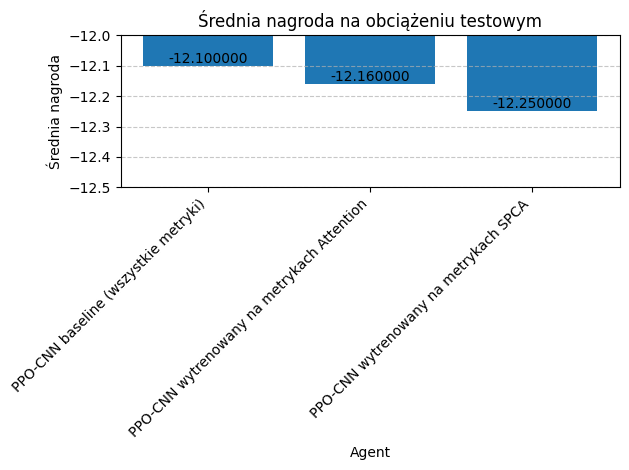

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of paths to DataFrame files
list_of_paths = [
                 
                 r'C:\initial_model\historic_synthetic_dnnevo\Cnn_baseline\ppo_CnnPolicy_cnn_baseline.csv',
                 r'C:\initial_model\historic_synthetic_dnnevo\Cnn_reduced\ppo_CnnPolicy_mlplstm_fake_metrics.csv',
                 r'C:\initial_model\historic_synthetic_dnnevo\Cnn_reduced_2\ppo_CnnPolicy_mlplstm_fake_metrics.csv'
                 
                 ]  # Example paths
labels = [#'PPO MLP - zbiór 1', 'PPO MLP - zbiór 2', 'PPO MLP - zbiór 3', 
          'PPO-CNN baseline (wszystkie metryki)', 'PPO-CNN wytrenowany na metrykach Attention', 'PPO-CNN wytrenowany na metrykach SPCA']
means = []
#labels = []

for path in list_of_paths:
    df = pd.read_csv(path)  # Adjust read function if necessary (e.g., pd.read_parquet)
    mean_rew = df['rew'].mean()
    means.append(mean_rew)
    labels = labels
    #labels.append(path.split('/')[-1])  # Use filename as label

print(means)
print(labels)
x_pos = np.arange(len(labels))
bars = plt.bar(x_pos, means)

# Set y-axis limits to focus on the range of interest
plt.ylim(-12.5, -12)

# Add value labels on top of each bar
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{mean_val:.6f}',  # Format to 6 decimal places for precision
             ha='center', va='bottom', rotation=0)

plt.xlabel('Agent')
plt.ylabel('Średnia nagroda')
plt.title('Średnia nagroda na obciążeniu testowym')
plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.tight_layout()

# Add a horizontal grid for better reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
